In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
from scipy.optimize import fmin

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist_cutoff
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist
from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print, u_core
from statmechlib.preprocessing import universal_eos

In [4]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

In [5]:
n = int((1.45-0.85)/0.05 + 0.01)
reos = np.linspace(0.85, 1.45, n+1)*2.74
#for i, scale in enumerate(np.linspace(0.85, 1.45, 13)):
#    print(round(reos[i], 3), universal_eos(scale, 'W'))

In [6]:
with open(os.path.join(working, 'stats_ready'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)

with open(os.path.join(working, 'target_ready'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [7]:
print(stats_ready['hyperparams'])

[2.5, 2.65, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.356, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75]


In [8]:
multi_index = []
multi_index.append([0, 2, 3, 5, 7, 10, 12, 15])
multi_index.append([0, 2, 4, 6, 8, 10, 12, 14])
multi_index.append([0, 2, 4, 6, 8, 11, 13, 15])
multi_index.append([1, 2, 3, 5, 7, 10, 12, 14])
multi_index.append([1, 2, 4, 6, 8, 11, 13, 15])
multi_index.append([1, 2, 4, 6, 9, 11, 13, 15])
multi_index.append([1, 3, 5, 7, 9, 11, 13, 15])

In [9]:
stats_opts = []
for index in multi_index:
    index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
    print(np.array(stats_ready['hyperparams'])[index])
    stats_opts.append(select_nodes(stats_ready, index))

[2.5  2.75 3.   3.5  4.   4.5  5.   5.75]
[2.5  2.75 3.25 3.75 4.25 4.5  5.   5.5 ]
[2.5  2.75 3.25 3.75 4.25 4.75 5.25 5.75]
[2.65 2.75 3.   3.5  4.   4.5  5.   5.5 ]
[2.65 2.75 3.25 3.75 4.25 4.75 5.25 5.75]
[2.65  2.75  3.25  3.75  4.356 4.75  5.25  5.75 ]
[2.65  3.    3.5   4.    4.356 4.75  5.25  5.75 ]


In [10]:
#with open(os.path.join(working, "stats_multi.pickle"), 'wb') as fo:
#    pickle.dump(stats_opts, fo)

In [11]:
#with open(os.path.join(working, "target_multi.pickle"), 'wb') as fo:
#    pickle.dump(targ_ready, fo)

In [12]:
# read corresponding parameters
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in)

[-0.344540412587315, 1.6869558429105695e-05, 0.4527535290774057, 7.091857873610367, 1.6314949612839302, 0.7906877956550405, -0.8249673243680319, 0.14501087706040938, -0.002061634677032549, 0.0021894588902290147]


In [13]:
with open(os.path.join(working, 'stats_multi.pickle'), 'rb') as fi:
    stats_opts = pickle.load(fi)

with open(os.path.join(working, 'target_multi.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [14]:
it = 6 # read in it (independent process)
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opts[it][key])
    target.append(targ_ready[key])

In [15]:
def optimize_EAM(target, stats, ieam, multi_pars, n_b=3):
    
    optimal_parameters = []
    
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [ieam])
        print(i,' sd2: ini', sd_ini, end='')
        output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [ieam]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        optimal_parameters.append(tuple([output[1], output[0]]))
        print('sd2: final', output[1])

    n_best = min(n_b, len(optimal_parameters))
                 
    best_params = sorted(optimal_parameters)[:n_best]
    
    print('Best params:', best_params)

    return best_params

In [16]:
multi_pars = []
multi_pars.append(pars_in)
multi_pars.append([-0.684229349, 0.000152487644, -65.6958142, 23.0194161, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974])
for _ in range(4):
    pars = np.array(multi_pars[1])
    pars += np.random.standard_normal(pars.shape)*0.07
    print(pars)
    multi_pars.append(pars)

[-7.05349043e-01  5.40587224e-02 -6.56052902e+01  2.29851665e+01
 -3.49068042e+00  3.53236343e+00 -8.97436227e-01 -1.14498216e+00
  1.11942993e+00 -4.89204325e-01]
[-7.66562455e-01  7.39231823e-03 -6.57385319e+01  2.30366036e+01
 -3.38634725e+00  3.59867444e+00 -8.93625045e-01 -1.38673014e+00
  1.31232437e+00 -3.69216521e-01]
[-7.82109380e-01 -1.13824910e-02 -6.57395758e+01  2.29657834e+01
 -3.42228090e+00  3.33719284e+00 -8.58798949e-01 -1.32576506e+00
  1.21921881e+00 -4.52094124e-01]
[-6.81581180e-01  1.86143393e-03 -6.57601033e+01  2.28267598e+01
 -3.47954270e+00  3.34414368e+00 -7.69853191e-01 -1.31433786e+00
  1.30046419e+00 -3.20224026e-01]


In [17]:
for ieam in range(4, len(stats_opts[it]['hyperparams'])):
    print('ieam:', ieam)
    for i in range(6):
        best_pars = optimize_EAM(target, stats, ieam, multi_pars)
        multi_pars = [p[1] for p in best_pars]

ieam: 4
0  sd2: ini 18.425863578695715sd2: final 0.0032147816492686244
1  sd2: ini 19.784570593582824sd2: final 0.0010068425902770937
2  sd2: ini 22.15250510033241sd2: final 0.008500402379824088
3  sd2: ini 21.265351795065488sd2: final 0.0030627373836336386
4  sd2: ini 16.04292139629084sd2: final 0.00732042125063797
5  sd2: ini 21.480683175744957sd2: final 0.011582384208828216
Best params: [(0.0010068425902770937, array([-2.37088501e+00,  5.37896949e-04,  4.35928594e+01, -1.02487281e+01,
        4.06865141e+00,  1.58300653e+00, -4.47543458e+00,  2.73799266e+00,
       -1.46805478e-01, -1.52009162e-01])), (0.0030627373836336386, array([ 6.48018027e-01,  1.70134960e-03,  4.61174473e+01, -1.40427002e+01,
        3.11377523e+00,  3.63580863e+00, -4.22323288e+00,  9.63673006e-01,
        6.42756875e-01, -3.82296409e-01])), (0.0032147816492686244, array([-2.26299733e+00,  4.37117634e-04,  1.72715190e-01,  1.67010857e+01,
       -8.52143109e+00,  7.63617828e+00, -5.29840272e+00,  1.71476551e+

0  sd2: ini 6.353304015797355e-05sd2: final 6.146391398082047e-05
1  sd2: ini 6.885359515219823e-05sd2: final 6.664369178670245e-05
2  sd2: ini 7.83847761311926e-05sd2: final 5.6705598887741184e-05
Best params: [(5.6705598887741184e-05, array([-7.57469912e-01,  3.22999133e-04,  2.78487751e+01, -1.74556286e+00,
       -2.07103397e-01,  4.11858057e+00, -4.78361539e+00,  1.87997479e+00,
        8.58688603e-02, -1.75571553e-01])), (6.146391398082047e-05, array([-7.79723699e-01,  3.18208163e-04,  2.69240565e+01, -9.28153811e-01,
       -9.99300893e-01,  4.84556480e+00, -5.06058541e+00,  1.70932653e+00,
        2.49072544e-01, -2.15293998e-01])), (6.664369178670245e-05, array([-7.94375156e-01,  3.08034399e-04,  2.93570214e+01, -2.36413250e+00,
        5.28838430e-01,  3.34373117e+00, -4.44055518e+00,  2.04329348e+00,
       -9.74274759e-02, -1.24292440e-01]))]
0  sd2: ini 5.6705598887741184e-05sd2: final 5.633494042584013e-05
1  sd2: ini 6.146391398082047e-05sd2: final 6.06477576218865e-05
2

0  sd2: ini 0.00010965439572822257sd2: final 5.3763718345140966e-05
1  sd2: ini 0.00022247731580462085sd2: final 0.00013051197511643756
2  sd2: ini 0.00023096222387204853sd2: final 0.00016785433626457342
Best params: [(5.3763718345140966e-05, array([-2.83080473e-01,  3.26452088e-05,  2.31034355e+01,  9.86602299e-02,
       -1.42064364e+00,  4.41581326e+00, -3.96431658e+00,  1.08635035e+00,
        1.41192771e-01, -1.28835729e-01])), (0.00013051197511643756, array([-1.48959310e-01,  3.82959058e-05,  2.53944670e+01, -3.54043190e+00,
        1.61420382e+00,  2.10660607e+00, -3.42242214e+00,  1.87139316e+00,
       -3.41729589e-01, -5.99718092e-02])), (0.00016785433626457342, array([-3.13821308e-01,  3.09807027e-05,  1.71642824e+01,  4.30394217e+00,
       -4.43602936e+00,  6.82067619e+00, -4.81701835e+00,  5.75554274e-01,
        5.88518849e-01, -2.29199388e-01]))]
0  sd2: ini 5.3763718345140966e-05sd2: final 5.3287693288696884e-05
1  sd2: ini 0.00013051197511643756sd2: final 0.0001250360

In [88]:
multi_pars

[array([-2.46692536e+00, -7.07645876e-04, -1.92990197e+02,  5.43710332e+01,
        -1.17019464e+01,  1.26314518e+00,  3.72747439e+00, -4.17045991e+00,
         2.46942853e+00, -4.39168938e-01]),
 array([-1.39247738e+00,  1.45832318e-03, -1.22829256e+02,  3.89427039e+01,
        -7.01985954e+00, -4.45624270e-01,  3.84825703e+00, -3.54791628e+00,
         1.89469535e+00, -3.48857885e-01])]

In [18]:
optimal_parameters = [(4.713164119688597e-05, [-2.79806563e-01,  3.25954186e-05,  2.38098641e+01, -3.49604675e-01,
       -9.13218975e-01,  3.90332338e+00, -3.75037798e+00,  1.20480869e+00,
        1.93771655e-02, -9.79262038e-02])]

5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1138.921776243323, -906.9768361235253, -1127.2574605132938, -1136.5040366024, -1136.7037550774967]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
0 4.713164119688597e-05


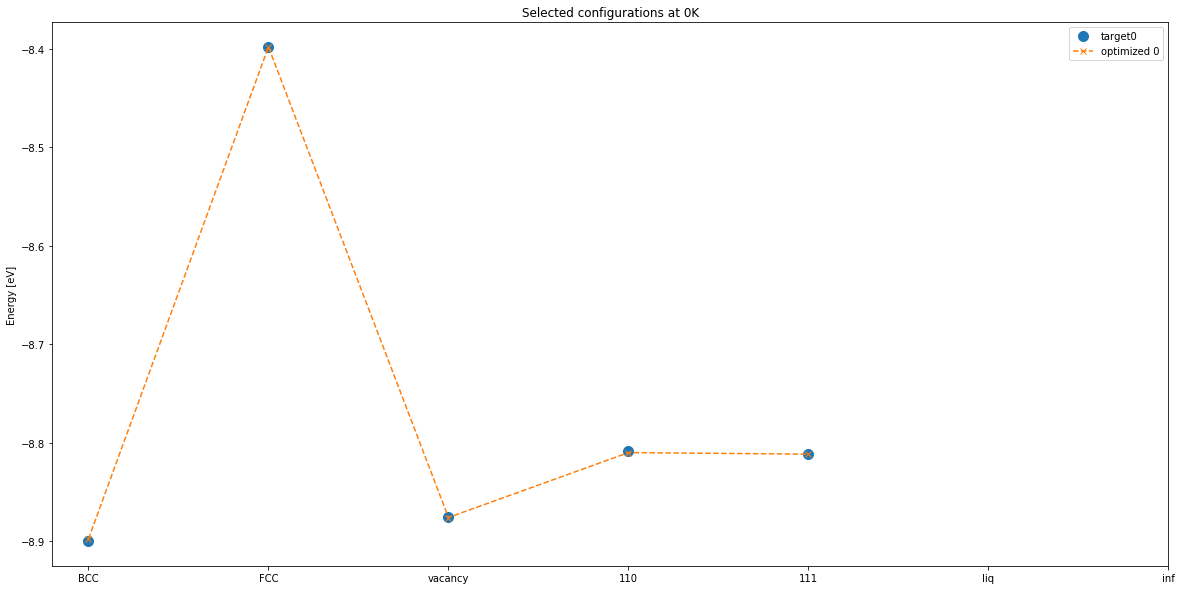

In [20]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:-2])
        print('Model:', opti_out[-2][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-2]))/nat)
        plt.plot(np.array(targ_out[-2][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-2][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

13
Targ: [-271.8047221070888, -837.1711089986524, -1079.5267350307165, -1139.2, -1100.8887858645915, -1014.6561261471663, -909.2807161131147, -800.6633444635341, -697.0611202328876, -602.3043063713144, -517.7429994565125, -443.4032853774631, -378.657941519064]
Model: [-270.4151000027956, -832.9056555818881, -1073.2638119856952, -1138.921776243323, -1099.6752704900018, -1017.0498488538274, -909.9928847273699, -795.407068360248, -689.4559578475628, -601.8905160076289, -523.7244212071614, -444.3614140803395, -372.8613301861641]
[0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625
 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625]
0 4.713164119688597e-05


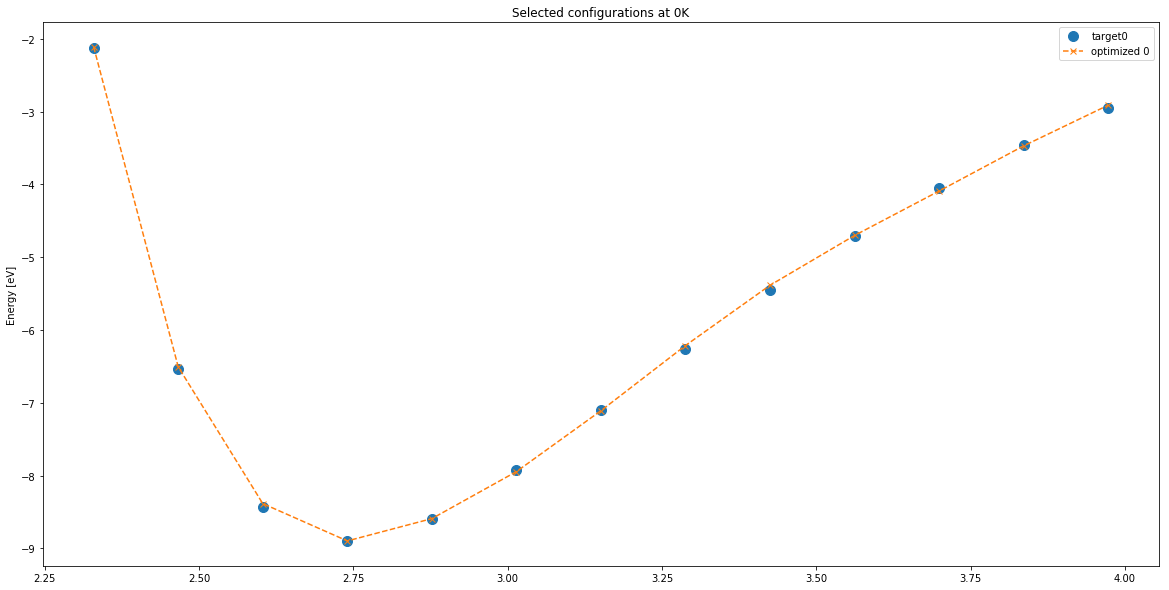

In [21]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos']['xyz']])[1:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][1:])
        print('Model:', opti_out[-1][1:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][1:]))/nat)
        plt.plot(reos, np.array(targ_out[-1][1:])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(reos, np.array([o for o in opti_out[-1][1:]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

1138
[8.890625 8.890625 8.890625 ... 8.890625 8.890625 8.890625]
0 4.713164119688597e-05


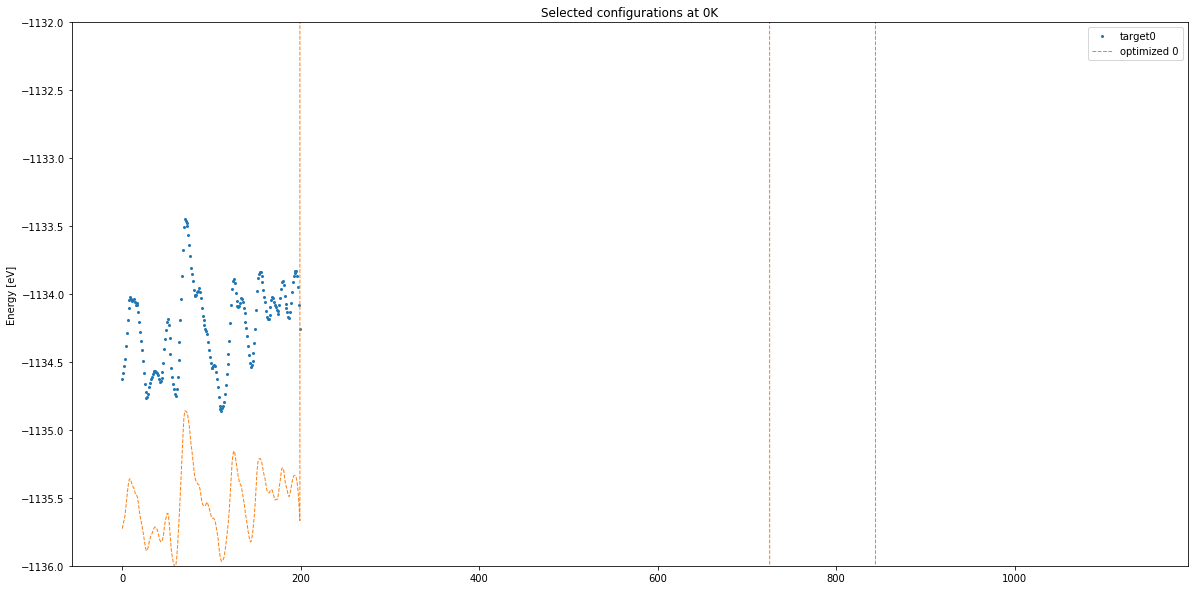

In [24]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=2)

        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

plt.ylim(-1180,-700)
plt.ylim(-1136,-1132)
#plt.ylim(-1000,-900)

plt.legend()

In [121]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

0 0.00012508417047382345 
 [-0.942576521, 7.61707891e-05, -105.811358, 36.1001559, -6.39102078, -0.0242484404, 2.91284708, -2.96955528, 1.3606181, -0.17478259]


In [126]:
stats_opt['hyperparams']

[2.65, 3.0, 3.5, 4.0, 4.356, 4.75, 5.25, 5.75]

In [127]:
stats_opts[it]['hyperparams']

[2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.75]

In [128]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 6
pars_out['params'] = [optimal_parameters[0]]

In [129]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [130]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [131]:
optimal_list

[{'pair_nodes': [2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.75],
  'mb_node': 6,
  'params': [(0.00012508417047382345,
    [-0.942576521,
     7.61707891e-05,
     -105.811358,
     36.1001559,
     -6.39102078,
     -0.0242484404,
     2.91284708,
     -2.96955528,
     1.3606181,
     -0.17478259])]}]

In [151]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [152]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [153]:
optimal_list[-1]['params'][0][1]

[-0.942576521,
 7.61707891e-05,
 -105.811358,
 36.1001559,
 -6.39102078,
 -0.0242484404,
 2.91284708,
 -2.96955528,
 1.3606181,
 -0.17478259]

In [154]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [155]:
pair_y, many_y, V_x_r, rho_x_r

([-105.811358,
  36.1001559,
  -6.39102078,
  -0.0242484404,
  2.91284708,
  -2.96955528,
  1.3606181,
  -0.17478259],
 [-0.942576521, 0.0, 7.61707891e-05],
 [2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.75],
 [5.0])

In [156]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

Text(0,0.5,'U')

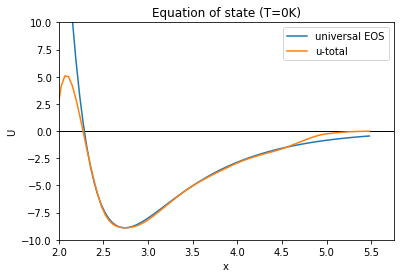

In [157]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.ylim(-10,10)

plt.xlabel('x')
plt.ylabel(r'U')

In [39]:
rho_a = [1.0]
rho_r = [stats_opt['hyperparams'][-1]]

pair_a = pars_in1[2:]
pair_r = stats_opt['hyperparams']

many_a = [pars_in[0], 0.0, pars_in[1]]

In [40]:
# Ranges of densities and separations

nr = 5000
rcut = stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
#rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 768.0


In [41]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [42]:

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [708]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lvnew.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))